# APLICACIONES DE CIENCIAS DE LA COMPUTACIÓN (INF265) 
PhD. Edwin Villanueva

<font color='orange'>Agente aspirador en una grilla cuadrada de 4 posiciones</font>

Al finalizar el presente laboratorio se debe tener implementado el entorno de trabajo del agente aspirador de 4 posiciones y un programa reflexivo simple para dicho agente. Las posiciones del entorno son denotadas como `loc_A`, `loc_B`, `loc_C`, y `loc_D`. Cada una de estas posiciones puede tener el estado `'Dirty'` o `'Clean'`.

A continuación, se tienen las etiquetas de las casillas del entorno:

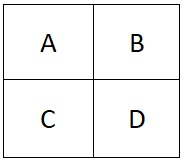

# Implementacion del Entorno  



#### <b>Clase Thing:</b> 
Esta clase generica representa cualquier objeto fisico que puede aparecer en un <b>Ambiente</b>. (No editar)  

In [ ]:
class Thing(object):

    def is_alive(self):
        """Cosas 'vivas'deben retornar true."""
        return hasattr(self, 'alive') and self.alive

    def show_state(self):
        """Muestra el estado interno del agente. Subclases deben sobreescribir esto."""
        print("I don't know how to show_state.")

#### <b>Clase Environment:</b>  
Esta es la clase que implementa un entorno generico</b>. Clases de entornos reales heredan de esta. En un entorno tipicamente se necesitará implementar 2 cosas:
<b>percept</b>, que define la percepción que el agente ve; y 
<b>execute_action</b>, que define los efectos de ejecutar una acción. 
El entorno mantiene una lista de .things y .agents (el cual es un subconjunto de .things). Cada elemento de .things tiene un slot .location. (No editar)

In [ ]:
class Environment(object):

    def __init__(self):
        self.things = []
        self.agents = []

    def thing_classes(self):
        return []  # List of classes that can go into environment

    def percept(self, agent):
        """Retorna la percepcion que el agente 'agent' ve en este punto."""
        raise NotImplementedError

    def execute_action(self, agent, action):
        """El agente 'agent' ejecuta una accion 'action' en el entorno."""
        raise NotImplementedError

    def default_location(self, thing):
        """Localización por defecto para colocar una nueva cosa sin localizacion especificada."""
        return None

    def is_done(self):
        """Retorna True si no hay ningun agente vivo"""
        return not any(agent.is_alive() for agent in self.agents)

    def add_thing(self, thing, location=None):
        """Añade una cosa thing al entorno en la localizacion location. 
           Si thing es un programa de agente, crea un nuevo agente con ese programa."""
        if not isinstance(thing, Thing):
            thing = Agent(thing)
        assert thing not in self.things, "No añade la misma cosa dos veces"
        thing.location = location if location is not None else self.default_location(thing)
        self.things.append(thing)
        if isinstance(thing, Agent):
            thing.performance = 0
            self.agents.append(thing)

    def step(self):
        """Ejecuta un paso del entorno (llama a los programas de los agentes, obtiene sus acciones y las ejecuta). """
        if not self.is_done():
            actions = []
            for agent in self.agents:
                if agent.alive:
                    actions.append(agent.program(self.percept(agent)))
                else:
                    actions.append("")
            for (agent, action) in zip(self.agents, actions):
                self.execute_action(agent, action)

    def run(self, steps=1000):
        """Ejecuta steps pasos en el entorno."""
        for step in range(steps):
            if self.is_done():
                return
            self.step()

#### Clase <b>VacuumEnvironment</b>

Esta clase implementa el entorno del aspirador de 4 posiciones: loc_A, loc_B, loc_C y loc_D. Cada una de estas posiciones puede tener el estado 'Dirty' o 'Clean'. Un agente en este entorno percibe su localizacion y el estado de la misma

In [ ]:
loc_A, loc_B, loc_C, loc_D = (0, 0), (1, 0), (0, 1), (1, 1)   # The 4 locations for the Vacuum world

class VacuumEnvironment(Environment):

    def __init__(self):
        super().__init__()
        self.status = {loc_A: random.choice(['Clean', 'Dirty']),
                       loc_B: random.choice(['Clean', 'Dirty']),
                       loc_C: random.choice(['Clean', 'Dirty']),
                       loc_D: random.choice(['Clean', 'Dirty'])}

    """Retorna las clases de objetos que estan disponibles en el entorno"""
    def thing_classes(self):
        return [ReflexVacuumAgent]

    def percept(self, agent):
        """Retorna la posicion del agente y el estado de la posicion (Dirty/Clean)."""
        return (agent.location, self.status[agent.location])

    def execute_action(self, agent, action):
        """Implementa el MAPA De TRANSICION: Cambia la posicion del agente y/o el estado de la posicion; 
        Cada aspiracion (accion 'suck') en una localizacion Dirty provoca un aumento de desempeño en 10 unidades;
        Cada movida efectiva Right, Left, Up o Down provoca una disminución de desempeño en 1 unidad """
        
        if action == 'Right':
            if agent.location == loc_A:
                agent.location = loc_B
                agent.performance -= 1
            elif agent.location == loc_C:
                agent.location = loc_D
                agent.performance -= 1
        elif action == 'Left':
            if agent.location == loc_B:
                agent.location = loc_A
                agent.performance -= 1
            elif agent.location == loc_D:
                agent.location = loc_C
                agent.performance -= 1
        if action == 'Up':
            if agent.location == loc_C:
                agent.location = loc_A
                agent.performance -= 1
            elif agent.location == loc_D:
                agent.location = loc_B
                agent.performance -= 1
        elif action == 'Down':
            if agent.location == loc_A:
                agent.location = loc_C
                agent.performance -= 1
            elif agent.location == loc_B:
                agent.location = loc_D
                agent.performance -= 1
        elif action == 'Suck':
            self.status[agent.location] = 'Clean'
            agent.performance += 10

    def default_location(self, thing):
        """Devuelve una posicion aleatoria."""
        return random.choice([loc_A, loc_B, loc_C, loc_D])


# Implementacion del Agente



#### Clase  Agent

Un agente es una subclase de Thing con un slot obligatorio: <b>.program</b>, el cual almacena la funcion que implementa el <b>programa del agente</b>. Esta funcion debe tomar como argumento la <b>percepcion</b> del agente y debe retornar una <b>accion</b>. La definicion de Percepcion y Accion depende del ambiente de trabajo (environment) donde el agente existe. El agente tambien puede tener el slot <b>.performance</b>, que mide el desempeño del agente en su ambiente.

In [ ]:
import collections
import random

class Agent(Thing):

    def __init__(self, program=None):
        self.alive = True
        self.performance = 0
        assert isinstance(program, collections.Callable)
        self.program = program

#### Programa Reactivo Simple para actuar en  el VacuumEnvironment

Esta es la implementacion del programa de agente para el entorno del aspirador de cuatro posiciones. Es un programa reactivo simple que realiza una accion basado en la percepción actual  (posicion, estado).

In [ ]:
def ReflexVacuumAgent():
    
    def program(percept):
        location, status = percept

        if status == 'Dirty':
            return 'Suck'
        elif location == loc_A:
            return 'Right'
        elif location == loc_B:
            return 'Down'
        elif location == loc_C:
            return 'Up'
        elif location == loc_D:
            return 'Left'
    return Agent(program)

# Probando el agente en VacuumEnvironment

In [ ]:
"""Crea el entorno del aspirador de 4 posiciones con 2 posiciones en estado 'Dirty'"""
e = VacuumEnvironment()
e.status = {loc_A: 'Clean',  loc_B: 'Dirty', loc_C: 'Dirty', loc_D: 'Clean'}

In [ ]:
"""Crea un agente reflexivo simple y lo añade al entorno en posicion loc_A"""
a = ReflexVacuumAgent()
e.add_thing(a, location=loc_A) 

In [ ]:
# Imprime el estado inicial del ambiente y localizacion del agente
print("Estado Inicial del Ambiente: {}".format(e.status))
print("ReflexVacuumAgent esta localizado en {} con desempeño = {}".format(a.location, a.performance))

Estado Inicial del Ambiente: {(0, 0): 'Clean', (1, 0): 'Dirty', (0, 1): 'Dirty', (1, 1): 'Clean'}
ReflexVacuumAgent esta localizado en (0, 0) con desempeño = 0


In [ ]:
"""Ejecuta el entorno 6 pasos y obtiene el desempeño del agente"""
e.run(5)

In [ ]:
# Imprime el estado actual del ambiente, localizacion del agente y su desempeño
print("Estado del Ambiente despues de 5 pasos: {}".format(e.status))
print("ReflexVacuumAgent esta localizado en {} con desempeño = {}".format(a.location, a.performance))

Estado del Ambiente despues de 5 pasos: {(0, 0): 'Clean', (1, 0): 'Clean', (0, 1): 'Clean', (1, 1): 'Clean'}
ReflexVacuumAgent esta localizado en (0, 1) con desempeño = 17
